In [1]:
import os, csv
import pandas as pd
from pyspark.sql import SparkSession, functions, types
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel('WARN')

# Read in data. We need to read in the first row of the CSV 
# to get the headers so we can dynamically create the schema.
DATA_DIR = '../../project_data/pipeline/peaks'
file_name = 'peak_1s.csv'

df_pd = pd.read_csv(os.path.join(DATA_DIR, file_name))
df = spark.createDataFrame(df_pd)



In [2]:
df.show()

+-------------------+--------+-----+------------------+-------------------+--------------------+------------------+------------------+-------------------+--------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+--------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-----------------

In [2]:
# confirm the labels are right
labels = df.select('label').collect()
falls = [l for l in labels if l[0] == 1]
non_falls = [l for l in labels if l[0] == 0]
print("Falls: {}, Non-falls: {}".format(len(falls), len(non_falls)))

features = [col for col in df.columns if col not in ['trial_id', 'label', 'Time']]
#features = [col for col in df.columns if col.endswith('res')]
train, validation = df.randomSplit([0.75, 0.25], seed=1234)
#print(features)

Falls: 3990, Non-falls: 60615


In [16]:
## ALGORITHM 1: Random Forest Classifier - without resultant vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Assemble Pipeline
assembler = VectorAssembler(
    inputCols=features,
    outputCol='features')
classifier = RandomForestClassifier(labelCol='label', maxDepth=20, numTrees=64, seed=1234)
pipeline = Pipeline(stages=[assembler, classifier])

# Set params to test
# maxDepth= [10, 20]
# numTrees =[32, 64]
# numFolds = 3
maxDepth= [20]
numTrees =[64]
numFolds = 3

paramGrid = ParamGridBuilder() \
    .addGrid(classifier.maxDepth, maxDepth) \
    .addGrid(classifier.numTrees, numTrees) \
    .build()

cv = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='weightedPrecision'),
                          numFolds=numFolds)  
model = cv.fit(train)

In [3]:
model_path = 'models_v2/rf_peaks_1s'
model = PipelineModel.load(model_path)

In [4]:
#best_pipeline = model.bestModel
# print("Best maxDepth: {}".format(best_pipeline.stages[1].getOrDefault('maxDepth')))
# print("Best numTrees: {}".format(best_pipeline.stages[1].getOrDefault('numTrees')))

predictions = model.transform(validation)

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
print("Test Area Under PR: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})))

evaluator = MulticlassClassificationEvaluator()
print("f1: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))
print("Weighted Precision: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})))
print("Weighted Recall: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})))
print("Accuracy: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))

Test Area Under ROC: 0.9963211041111392
Test Area Under PR: 0.9683055515400433
f1: 0.9870941348963688
Weighted Precision: 0.9876777270135175
Weighted Recall: 0.9876597070738549
Accuracy: 0.9876597070738548


Normalized confusion matrix
[[9.99401317e-01 5.98682898e-04]
 [1.86758893e-01 8.13241107e-01]]


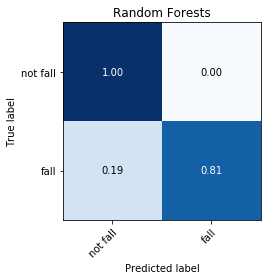

<Figure size 7200x4800 with 0 Axes>

In [8]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=['not fall', 'fall'], yticklabels=['not fall', 'fall'],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array([0,1])
#class_names = ['Non-fall', 'Fall']
y_test = [int(i[0]) for i in predictions.select('label').collect()]
y_predict = [int(i[0]) for i in predictions.select('prediction').collect()]
#print(y_test)
plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,title='Random Forests')
plt.figure(dpi=1200)                                   
plt.show()

In [35]:
MODEL_DIR = 'models_v2'
best_pipeline.write().overwrite().save(os.path.join(MODEL_DIR, 'rf_peaks_1s'))

In [19]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
y_test = [int(i[0]) for i in predictions.select('label').collect()]
y_pred = [int(i[0]) for i in predictions.select('prediction').collect()]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [20]:
#https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

#f = ExtractFeatureImp(best_pipeline.stages[-1].featureImportances, predictions, "features")
f = ExtractFeatureImp(best_pipeline.stages[-1].featureImportances, predictions, "features")
top_20_features = list(f['name'].head(20).values)
f.head(10)

idx               name     score
48   48        r_thi_Acc_X  0.089971
60   60          ste_Acc_X  0.080877
72   72          wai_Acc_X  0.064622
24   24        l_thi_Acc_X  0.057379
0     0          hea_Acc_X  0.050699
44   44    r_ank_Mag_Fie_X  0.039529
20   20    l_ank_Mag_Fie_X  0.023704
55   55  r_thi_Ang_Vel_res  0.021416
36   36        r_ank_Acc_X  0.021359
12   12        l_ank_Acc_X  0.019789

In [21]:
d = f[['name', 'score']].head(10)
d

name     score
48        r_thi_Acc_X  0.089971
60          ste_Acc_X  0.080877
72          wai_Acc_X  0.064622
24        l_thi_Acc_X  0.057379
0           hea_Acc_X  0.050699
44    r_ank_Mag_Fie_X  0.039529
20    l_ank_Mag_Fie_X  0.023704
55  r_thi_Ang_Vel_res  0.021416
36        r_ank_Acc_X  0.021359
12        l_ank_Acc_X  0.019789

[Text(0, 0.5, 'Feature Importance'),
 Text(0.5, 0, 'Sensor Measurement'),
 Text(0.5, 1.0, 'Top 10 Most Important Features')]

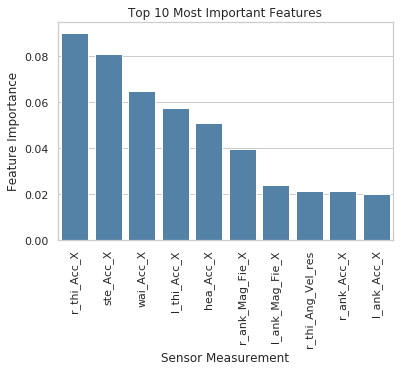

In [25]:
import seaborn as sns
sns.set(style="whitegrid")
#sns.palplot(sns.color_palette("GnBu_d"))
ax = sns.barplot(x="name", y="score", data=d, color='steelblue')#palette=("hls"))
ax.set_xticklabels(d['name'], rotation=90)
ax.set(xlabel='Sensor Measurement', ylabel='Feature Importance', title='Top 10 Most Important Features')


In [2]:
# ALGORITHM 2: Gradient Boosted Trees
# Can either train it here or load what has already been trained


# Assemble Pipeline
assembler = VectorAssembler(
    inputCols=features,
    outputCol='features')
classifier = GBTClassifier(maxIter=50, maxDepth=10, maxBins=50,seed=1)
pipeline = Pipeline(stages=[assembler, classifier])

# Set params to test
# maxDepth= [10, 20]
# maxBins =[32, 64]
# maxIter = [10, 20, 30]
maxDepth= [10]
maxBins =[64]
maxIter = [30]

paramGrid = ParamGridBuilder() \
    .addGrid(classifier.maxDepth, maxDepth) \
    .addGrid(classifier.maxBins, maxBins) \
    .addGrid(classifier.maxIter, maxIter) \
    .build()

cv = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='weightedPrecision'),
                          numFolds=numFolds)  
model = cv.fit(train)

NameError: name 'VectorAssembler' is not defined

In [9]:
# best_pipeline = model.bestModel
# MODEL_DIR = 'models_v2'
# best_pipeline.write().overwrite().save(os.path.join(MODEL_DIR, 'gbt_peak_1s'))

model_path = 'models_v2/gbt_peak_1s'
model = PipelineModel.load(model_path)

In [10]:
# print("Best maxDepth: {}".format(best_pipeline.stages[1].getOrDefault('maxDepth')))
# print("Best maxIter: {}".format(best_pipeline.stages[1].getOrDefault('maxIter')))
# print("Best maxBins: {}".format(best_pipeline.stages[1].getOrDefault('maxBins')))

predictions = model.transform(validation)

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
print("Test Area Under PR: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})))

evaluator = MulticlassClassificationEvaluator()
print("f1: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))
print("Weighted Precision: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})))
print("Weighted Recall: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})))
print("Accuracy: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))

Test Area Under ROC: 0.9943262503651372
Test Area Under PR: 0.9575635676792079
f1: 0.9819742761311454
Weighted Precision: 0.9819119225159539
Weighted Recall: 0.9824867559987535
Accuracy: 0.9824867559987535


Normalized confusion matrix
[[0.99461185 0.00538815]
 [0.19762846 0.80237154]]


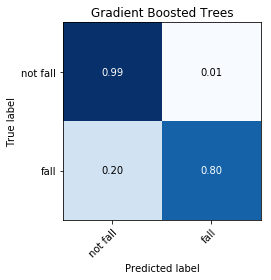

<Figure size 7200x4800 with 0 Axes>

In [11]:
class_names = np.array([0,1])
y_test = [int(i[0]) for i in predictions.select('label').collect()]
y_predict = [int(i[0]) for i in predictions.select('prediction').collect()]
#print(y_test)
plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,title='Gradient Boosted Trees')
plt.figure(dpi=1200)                                        
plt.show()

In [30]:
## ALGORITHM 3: Decision tree classifier 

# Assemble Pipeline
assembler = VectorAssembler(
    inputCols=features,
    outputCol='features')
classifier = DecisionTreeClassifier(labelCol='label', maxDepth=20, maxBins=50, seed=1234)
pipeline = Pipeline(stages=[assembler, classifier])

# Set params to test
# maxDepth= [10, 20]
# numTrees =[32, 64]
# numFolds = 3
maxDepth= [20]
maxBins =[50]
numFolds = 3

paramGrid = ParamGridBuilder() \
    .addGrid(classifier.maxDepth, maxDepth) \
    .addGrid(classifier.maxBins, maxBins) \
    .build()

cv = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='weightedPrecision'),
                          numFolds=numFolds)  
model = cv.fit(train)


In [12]:
model_path = 'models_v2/dt_1s_peak'
model = PipelineModel.load(model_path)

In [13]:
# best_pipeline = model.bestModel
# best_pipeline.write().overwrite().save(os.path.join(MODEL_DIR, 'dt_1s_peak'))

predictions = model.transform(validation)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
print("Test Area Under PR: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})))

evaluator = MulticlassClassificationEvaluator()
print("f1: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))
print("Weighted Precision: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})))
print("Weighted Recall: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})))
print("Accuracy: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))

Test Area Under ROC: 0.8245733562710126
Test Area Under PR: 0.7550884589239272
f1: 0.9774735865222038
Weighted Precision: 0.9773453269549564
Weighted Recall: 0.9776254284823933
Accuracy: 0.9776254284823933


In [32]:
best_pipeline = model.bestModel
best_pipeline.write().overwrite().save(os.path.join(MODEL_DIR, 'dt_1s_peak'))

Normalized confusion matrix
[[0.98902415 0.01097585]
 [0.1916996  0.8083004 ]]


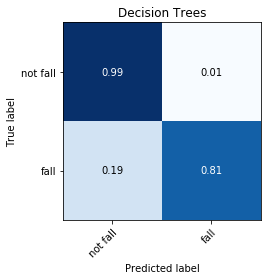

<Figure size 7200x4800 with 0 Axes>

In [14]:
class_names = np.array([0,1])
y_test = [int(i[0]) for i in predictions.select('label').collect()]
y_predict = [int(i[0]) for i in predictions.select('prediction').collect()]
#print(y_test)
plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,title='Decision Trees')
plt.figure(dpi=1200)                                        
plt.show()